# Kaggle competition report

***Student:*** Filipe Lauar.

## Introduction

This challange is divided into a binary and a multiclass problem releated to cell images. There are 4173 (2921 for train and 1252 for test) Pap smear cells RGB images with their relative segmentations of the nucleus and cytoplasma in this dataset. Some of these images came from the DTU/HERLEV dataset and some of them from the SIPaKMeD dataset. These cells are used to detect cervical cancer in womem [1] so detecting the cancer in the cells are a very important task.

In the binary problem, we have normal and abnormal cells. In the multiclass problem, we have 9 classes that describes the group of the cell.

In order to solve the problem, I decided to use a CNN pre-trained from the ImageNet dataset and then fine tune this network. I decided to use CNNs instead of manual feature extraction because since the AlexNet, CNN neural networks are being used instead of classical approach for image detection, as we can see in this graph [2].

The reason behind using a pre-trained CNN from the ImageNet dataset is that this dataset has millions of images from 1000 classes, which means that the learned features (convolutional weights) are generalized enought to work with any kind of data. To perform the fine tuning, I could freeze some of the convolutional layers (which mean that they would not 'learn' anymore) or retrain all of the layers with a small learning rate. I prefered to retrain all of the layers with a smaller learning rate because the domain is very different, which means that the network may still have something to learn even in the first layers.

I mainly tried 3 CNNs architectures, Resnet18, Resnet50 and EfficientNet b7. I chose these 3 architectures because they historically have good results when regardin image detection benchmarks [2] and because they have different sizes. Resnets were proposed in [3], Resnet18 is a small network, with only 11 million parameters, Resne50 is slighly bigger, with 26 million parameters. EfficientNet b7 is an architecture proposed in [4] that is achieving great results in different datasets and is being used behind some new architectures, such as the actual state of art for image detection, the Meta Pseudo Labels network. The EfficientNet b7 has 66 million parameters. I also though about using the Meta Pseudo Labels network, but it has 480 million parameters.

I tried different approaches for both problems. If an approach seemed good I tried it for both problems. I used pytorch as the framework because it's easier to do any modification I want.

My first approach was just fine tune a Resnet18 for 10 epochs in all of data and then make the predictions. With this I was able to get a 96% Matthews Correlation Coefficient (MCC) on the test set for the binary problem and 76% Weighted Categorization Accuracy (WCA). I went from these result to try some other techiniques in order to improve them.

My second approach was to use data augmentation. I tried to use random horizontal and vertical flip, rotation and collor jitter, that changes the hue and the saturation. It didin't gave me good results.

My third approach was to split the dataset in a training and validation samples. I used this to tune some hyperparameters such as the batch size, and the optimzer learning rate, momentum and weight decay. It was great to fix the hyper parameters but it didn't leaded me to a good enought result. With this approach I got a 97% MCC for the binary problem and 81% WCA for the multiclass problem.

My fourth approach was to include the nucleus and cytoplasm segmetions as extra channels of the image. The results using this were quite bad so I left this approach very quickly.

My fifth and last approach was to use KFold cross validation and to the prediction based on the majority votes. I used 5 folds, which means that each time 80% of the data was used for the training and 20% for validation. This approach really improved my results and with it I was able to achieve 98% MCC for the binary problem and 84% WCA for the multiclass problem.

For the binary classification problem, I used a batch size of 10 images, and a max of 50 epochs for each model with an early stopping of 15 epochs based on the MCC of the validation set. Using this approach I was able to win the binary classification challange in both public and private data. For this problem, I submitted my best result on the public data with and without data augmentation.

For the multiclass problem, I also used a max of 50 epochs with an early stopping of 15 epochs based on the WCA in the validation data, the difference was that I used a batch of size 60. I increased the batch size to have a better weight when calculating the metric. Using this approach I was able to win the multiclass classification challange in the public data and got the second place in the private data. For this problem I submitted my two best predictions without using data augmentation. If I had used my best result with data augmentation I would have won this challange in the private data also. (Learned lesson, use data augmentation).

Below is the code that generated the predictions to win the binary classification challange. There are a few small changes when dealing with the multiclass problem and I will explain them when it's needed. If you run this code you may not achieve the exact same result as I did because I forgot to set the random state of KFold. However, you may achieve a very similar result.

In [ ]:
# Basic imports
import os
import time
import numpy as np
import torch
import pandas as pd
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Pytorch imports
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from torch.backends import cudnn

from torchvision.models import resnet50
from torchvision import transforms

# Read file
from skimage import io

# For the kFold cross validation
from sklearn.model_selection import KFold

# MCC for the binary problem and balanced accuracy for the multiclass problem
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score

# To do the final predictions
from collections import Counter

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

cudnn.benchmark = True

In [ ]:
#Download the data

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18V-K1svKn2F2elbRM2sV4SphvQ01zBuP',
                                    dest_path='./data/Train.zip',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1mXkNmrzvNoD9CXwNQ5jgjhCwYiXKUq7Y',
                                    dest_path='./data/Test.zip',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1nOmZOUtmTsDMf4umX0VQkR1Sv7V6nMZh',
dest_path='./data/SampleSubmission.csv')

gdd.download_file_from_google_drive(file_id='1QZjgXocMHa50he30yAzZ0--ymtrkWx6q',
dest_path='./data/metadataTrain.csv')

Unzipping...Done.
Unzipping...Done.


## Defining the hyperparameters

These are some hyperparameters used in the challenge and setting the device to cuda if it's available. They were chosen using a lot of experiments with validation sets. For the image size, all the three used architectures were proposed to use with images of size 224, so I resize the images to this size. Also, this size is not that far from the mean size of the original images, that is (203,181).

These are the arguments for the binary problem. To the multiclass problem, we need to change n_out=9 and batch_size=60.

In [ ]:
# Setting predefined arguments.
args = {
    'n_out': 2,            #Number of output features
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 10,    # Mini-batch size.
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Utils

This is the implementation of the pytorch Dataset class, that was done to manage both binary and multiclass problems.

In [ ]:
class dataset(Dataset):
    '''Pap smear slides dataset'''

    def __init__(self, csv_file, root, transform=None, problem_type='binary'):
        '''
        Args:
            csv_file (string): Path to the csv file with annotations.
            root (string): Directory with all the images.
        '''

        self.problem_type = problem_type
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transformer = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.labels.iloc[idx, 0]
        img_name = os.path.join(self.root, str(img_id)+'.bmp')

        img = io.imread(img_name)

        if self.problem_type == 'binary':
            label = self.labels.iloc[idx, 1]
        else:
            label = self.labels.iloc[idx, 2]

        if self.transformer is not None:
            img = self.transformer(img)

        return img, label



## Preprocessing

These are the used transformers. The data augmentation opperations are commented. When using data augmentation, I had to assign all the dataset for two variables because when testing the network in the validation set I don't use data augmentation. It isn't a problem, because pytorch only load the images when they are being used, so this don't take memory space.

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((args['h_size'], args['w_size'])),  
    #transforms.ColorJitter(hue=.05, saturation=.05),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),       
    #transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

labels_path = './data/metadataTrain.csv'
data_path = './data/Train'

train_data = dataset(labels_path, data_path, data_transform)


data_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((args['h_size'], args['w_size'])),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_data = dataset(labels_path, data_path, data_transform_test)

In [ ]:
multiclass_images = dataset(labels_path, data_path, data_transform_test, problem_type='multiclass')

## Image visualization

Now let's check 10 images from the dataset with its binary labels. As we can see, the abnormal cells are darker than the normal ones. However, as I'm not a doctor, it's hard to really explain how to discriminate between normal and abnormal cells, I will let this task for the algorithm.

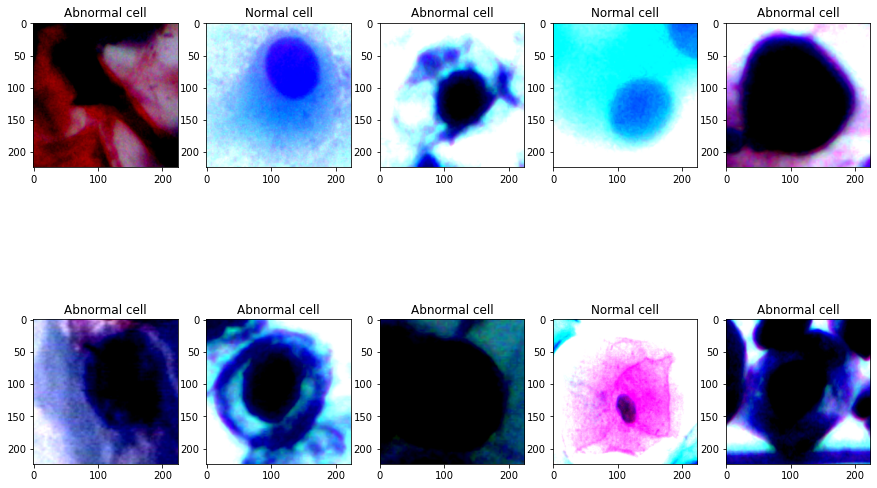

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15,10))
j=0
k=0
for i in range(10):
    ax[j,k].imshow(valid_data[i][0].numpy().transpose(1, 2, 0))
    if valid_data[i][1] == 0:
        ax[j,k].set_title('Normal cell')
    else:
        ax[j,k].set_title('Abnormal cell')
    k+=1
    if k ==5: k=0; j=1;
plt.show()

Now let's check 10 images from the dataset with its binary multiclass labels. We can see that is very hard to distinguish between the classes.

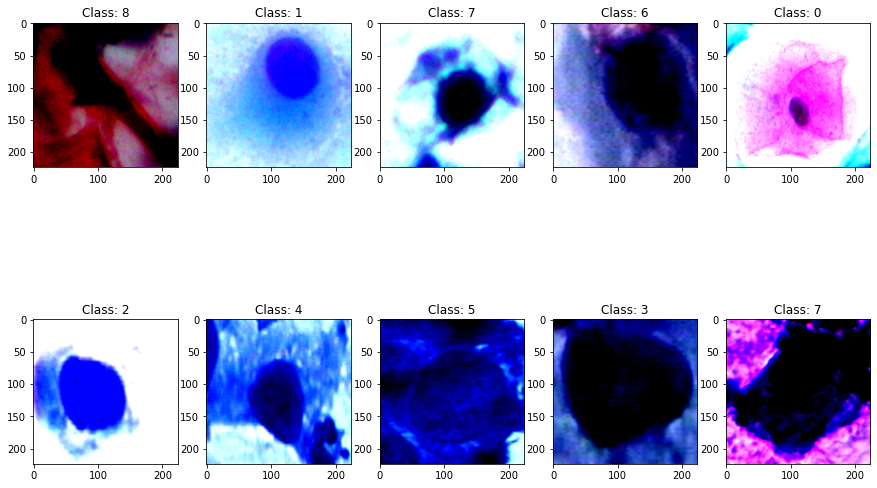

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15,10))
i=0
j=0
k=0
labels=[]
while True:
    if multiclass_images[i][1] not in labels:
        ax[j,k].imshow(multiclass_images[i][0].numpy().transpose(1, 2, 0))
        ax[j,k].set_title('Class: '+ str(multiclass_images[i][1]))
        labels.append(multiclass_images[i][1])
        k+=1;
        if k ==5: 
            k=0; j=1;
            
    i+=1
    
    if len(labels) == 9:
        ax[j,k].imshow(multiclass_images[i][0].numpy().transpose(1, 2, 0))
        ax[j,k].set_title('Class: '+ str(multiclass_images[i][1]))
        break
        
plt.show()

***Check if the data is balanced.***

We can see below that the binary labels are balanced.

In [ ]:
lab=0
for _, label in train_data:
    lab+=label

In [ ]:
print(str(1-(lab/len(train_data)))+'% of the data is from class 0.')
print(str(lab/len(train_data))+'% of the data is from class 1.')

0.4457377610407395% of the data is from class 0.
0.5542622389592605% of the data is from class 1.


For the multiclass dataset, we can see that its labels are not balanced. The classes 0, 1, 7 and 8 corresponds to 80% of the data, and the classes 2, 3, 4, 5 and 6 corresponds to the other 20% of the data.

In [ ]:
labs=[]
for _, label in multiclass_images:
    labs.append(label)

In [ ]:
counters = Counter(labs)
for i in range(len(counters)):
    print("Class:", i, "frequency:", counters[i]/len(labs))

Class: 0 frequency: 0.23348168435467306
Class: 1 frequency: 0.18863402944197194
Class: 2 frequency: 0.023622047244094488
Class: 3 frequency: 0.0359465936323177
Class: 4 frequency: 0.043478260869565216
Class: 5 frequency: 0.034919548099965766
Class: 6 frequency: 0.047244094488188976
Class: 7 frequency: 0.19787743923313933
Class: 8 frequency: 0.19479630263608352


## Tested models

Below are the three tested models. The both resnets were loaded from the torchvision.models module, and the Efficient net was loaded from its pytorch github repository. All of them loaded with the ImageNet pre-trained weights and then we change the last layer for our problem (binary 2 output features and multiclass 9 output features).

***Resnet18***

In [ ]:
# from torchvision.models import resnet18
# model = resnet18(pretrained=True).to(args['device'])
# features = model.fc.in_features
# model.fc = nn.Linear(in_features=features, out_features=args['n_out'], bias=True).to(args['device'])

***Resnet50***

In [ ]:
# from torchvision.models import resnet50
# model = resnet50(pretrained=True).to(args['device'])
# features = model.fc.in_features
# model.fc = nn.Linear(in_features=features, out_features=args['n_out'], bias=True).to(args['device'])

***Efficient net b7***

In [ ]:
# pip install efficientnet_pytorch

In [ ]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b7').to(args['device'])
# features = model._fc.in_features
# model._fc = nn.Linear(in_features=features, out_features=args['n_out'], bias=True).to(args['device'])

***Optimizer and loss***

As I use a cross validation techinique, the optimizer is instanciated inside the training loop for each model.

In [ ]:
# optimizer = optim.Adam(model.parameters(),
#                        lr=args['lr'],
#                        betas=(args['momentum'], 0.999),
#                        weight_decay=args['weight_decay'])

criterion = nn.CrossEntropyLoss().to(args['device'])

***Training loop***

In [ ]:
def cross_valid(train_data, valid_data, criterion, kfold, epoch=20, early_stop=5):
    
    # List of best model weights and best valid mcc for each fold
    best_model_weights = []
    best_valid_mcc = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data)):

        best_loss = 10000
        best_mcc = 0

        es=0
        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
                          train_data, 
                          args['batch_size'],
                          num_workers=args['num_workers'], sampler=train_subsampler)
        valid_loader = torch.utils.data.DataLoader(
                          valid_data,
                          args['batch_size'],
                          num_workers=args['num_workers'], sampler=test_subsampler)
        
        # Load the model
        model = resnet50(pretrained=True).to(args['device'])
        features = model.fc.in_features
        model.fc = nn.Linear(in_features=features, out_features=args['n_out'], bias=True).to(args['device'])
        
        # Set the optimizer
        optimizer = optim.Adam(model.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])
        
        print("Fold:", fold+1)
        for epoch in range(1, epoch + 1):
            tic = time.time()

            es+=1

            # Lists for losses and metrics.
            train_loss = []
            train_mcc = []

            valid_loss = []
            valid_mcc = []
            
            for i, batch_data in enumerate(train_loader):
            
                # Set model to training mode
                model.train()
                
                # Obtaining images, labels and paths for batch.
                inps, labs = batch_data

                # Casting to cuda variables.
                inps = inps.to(args['device'])
                labs = labs.to(args['device'])

                # Clears the gradients of optimizer.
                optimizer.zero_grad()

                # Forwarding.
                outs = model(inps)
                _, preds = torch.max(outs, 1)

                # Computing loss.
                loss = criterion(outs, labs)

                # Computing backpropagation.
                loss.backward()
                optimizer.step()

                # Updating lists.
                train_loss.append(loss.data.item())
                # Casting to CPU variables
                train_mcc.append(matthews_corrcoef(preds.cpu().detach().numpy(), labs.data.cpu().detach().numpy()))

            # Set model to evaluation mode
            model.eval()
            with torch.no_grad():  
                for i, batch_data in enumerate(valid_loader):

                    # Obtaining images, labels and paths for batch.
                    inps, labs = batch_data

                    # Casting to cuda variables.
                    inps = inps.to(args['device'])
                    labs = labs.to(args['device'])

                    # Forwarding.
                    outs = model(inps)
                    _, preds = torch.max(outs, 1)

                    # Computing loss.
                    loss = criterion(outs, labs)

                    # Updating lists.
                    valid_loss.append(loss.data.item())
                    # Casting to CPU variables
                    valid_mcc.append(matthews_corrcoef(preds.cpu().detach().numpy(), labs.data.cpu().detach().numpy()))


            toc = time.time()

            train_loss = np.asarray(train_loss)
            train_mcc = np.asarray(train_mcc)

            valid_loss = np.asarray(valid_loss)
            valid_mcc = np.asarray(valid_mcc)

            # Retain model weights of the best epoch and print it
            if valid_mcc.mean() > best_mcc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_mcc = valid_mcc.mean()
                best_loss = valid_loss.mean()
                es=0

                print('--------------------------------------------------------------------')
                print('[epoch %d] , [time %.2f]' % (
                    epoch, (toc - tic)))
                print('Train: [loss %.4f +/- %.4f], [mcc %.3f +/- %.3f]' % (
                    train_loss.mean(),  train_loss.std(), train_mcc.mean(), train_mcc.std()))
                print('Valid: [loss %.4f +/- %.4f], [mcc %.3f +/- %.3f]' % (
                    valid_loss.mean(),  valid_loss.std(), valid_mcc.mean(), valid_mcc.std()))
                print('--------------------------------------------------------------------')

            # Early stopping condition
            if es >= early_stop:
                break
                
        best_model_weights.append(best_model_wts)
        best_valid_mcc.append(best_mcc)
        
    return best_model_weights, best_valid_mcc

In [ ]:
model_wgts, best_mcc = cross_valid(train_data, valid_data, criterion, KFold(n_splits=5, shuffle=True),
                                   epoch=50, early_stop=15)

Fold: 1
--------------------------------------------------------------------
[epoch 1] , [time 21.93]
Train: [loss 0.2684 +/- 0.2420], [mcc 0.802 +/- 0.231]
Valid: [loss 0.1435 +/- 0.1118], [mcc 0.889 +/- 0.141]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2] , [time 22.38]
Train: [loss 0.1590 +/- 0.2271], [mcc 0.892 +/- 0.168]
Valid: [loss 0.1193 +/- 0.2012], [mcc 0.947 +/- 0.101]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 6] , [time 22.36]
Train: [loss 0.0768 +/- 0.1586], [mcc 0.943 +/- 0.124]
Valid: [loss 0.0654 +/- 0.1365], [mcc 0.969 +/- 0.082]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 7] , [time 21.97]
Train: [loss 0.0836 +/- 0.1839], [mcc 0.941 +/- 0.145]
Valid: [loss 0.0405 +/- 

***Loading and preprocessing test data***

Load the test data and apply the transformations on it.

In [ ]:
data_transform_test = transforms.Compose([
    transforms.Resize((args['h_size'], args['w_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

submission_path = '../data/SampleSubmission.csv'
test_data_path = '/data/Test/'

test_data = dataset(submission_path, test_data_path, data_transform)

***Loading the submission file***

In [ ]:
samp_sub = pd.read_csv(submission_path)

***Making the predictions***

For the predictions, I used the output of the five trained models and the final predictions is the class that had the majority of votes.

In [ ]:
nrow = samp_sub.shape[0]
d = {'m1': np.zeros(nrow), 'm2':  np.zeros(nrow), 'm3':  np.zeros(nrow), 'm4':  np.zeros(nrow), 'm5':  np.zeros(nrow)}
df = pd.DataFrame(data=d)

In [ ]:
for col in range(len(model_wgts)):
    # Load the model without pretrained weights to be faster
    model = resnet50(pretrained=False).to(args['device'])
    features = model.fc.in_features
    model.fc = nn.Linear(in_features=features, out_features=args['n_out'], bias=True).to(args['device'])
    model.load_state_dict(model_wgts[col])
    # Set the model to evaluation mode
    model.eval() 
    i=0
    for test, _ in test_data:
        # Reshape the data as the model expects a batch and we are inputing only one image
        test = test.to(args['device'], dtype=torch.float).reshape(1,train_data[0][0].shape[0],args['h_size'], args['w_size'])
        outs = model(test)
        _, preds = torch.max(outs, 1)
        df.iloc[i,col] = preds.cpu().detach().numpy()
        i=i+1

In [ ]:
for i in range(df.shape[0]):
    # Predict based on the most predicted class by the five models -> "majority vote"
    samp_sub.iloc[i,1] = int(Counter(df.iloc[i,]).most_common(1)[0][0])
    
samp_sub.to_csv('sub.csv', index=False)

In [ ]:
#Show some predictions
samp_sub

,ID,ABNORMAL
0,3421,1
1,2573,1
2,3358,1
3,597,1
4,4977,0
...,...,...
1247,1724,0
1248,3793,1
1249,2916,0
1250,1969,0


## Conclusion

We saw in this notebook different approaches using CNNs to classify Pap Smear Cells. As a conclusion of this work I would say that spliting the data into a training and validation set to control overfitting is very important. Also, use cross validation to train the model and make the predictions based on the "majority vote" of the models is a good approach and not hard to implement with pytorch. This approach generalizes very well, as I had close results in the training, validation and both public and private test datasets.

A learning of this challange is to always consider also a solution with data augmentation.

Something that I could do to improve the results would be a increase the number of cross validation folds from 5 to 10. I could also do the cross validation with and without data augmentation, having now the double of models and make the predictions based on all of them. However, these two improvements would take to much time to run.

## References

.[1] https://www.mayoclinic.org/tests-procedures/pap-smear/about/pac-20394841

.[2] https://paperswithcode.com/sota/image-classification-on-imagenet

.[3] https://arxiv.org/abs/1512.03385 - Deep Residual Learning for Image Recognition

.[4] https://arxiv.org/abs/1905.11946 - EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks